In [22]:
using  Parameters
using  LinearAlgebra
using  Roots
using Interpolations
using Plots
include("EGM.jl") #这里我们调用我们自己写的EGM函数


SolveEGM (generic function with 1 method)

In [ ]:
# 设置参数
@with_kw struct Par
    alpha::Float64 = 0.4
    beta::Float64 = 0.98
    gamma::Float64 = 2.0
    delta::Float64 = 0.02
    rho::Float64 = 0.95
end
par = Par()

struct HAGrids
    a::Vectors{Float64}  # 使用 Vector{Float64} 更符合 Julia 的类型习惯
    na::Int64
    e::Vector{Float64}
    ne::Int64
    Pi_e::Matrix{Float64}
end

function HAGrids()
    amin = 0.0
    Ne = 2
    lamw = 0.6
    sigma = 0.2
    exogTrans = [1 - lamw lamw; sigma 1 - sigma]  # 矩阵定义中不需要逗号

    endow = [1.0, 2.5]  # 确保数组元素是 Float64
    Lbar = sum(endow .* distributionSS(exogTrans))  # 确保 distributionSS 函数已定义
    endow = endow / Lbar
    Lbar = 1.0  # 重新定义 Lbar 为 1.0

    agridmin, agridmax, agridsize = amin, 400.0, 201
    agrid = range(agridmin^(0.25), agridmax^(0.25), length=agridsize).^4

    return HAGrids(agrid, agridsize, endow, Ne, exogTrans)
end

grid = HAGrids()
# 设置网格

HAGrids([0.0, 2.5e-7, 4.0e-6, 2.0250000000000004e-5, 6.4e-5, 0.00015625000000000006, 0.00032400000000000007, 0.0006002500000000001, 0.001024, 0.00164025  …  332.71584025000004, 339.7386240000001, 346.8720002500001, 354.11712400000016, 361.47515625000017, 368.9472639999999, 376.53462025, 384.238404, 392.05980025, 400.00000000000006], 201, [0.47058823529411764, 1.1764705882352942], 2, [0.4 0.6; 0.2 0.8])

In [24]:
    beta::Float64 = 0.98
    gamma::Float64 = 2.0
    delta::Float64 = 0.02
    rho::Float64 = 0.95
end
par = Par()

struct HAGrids
    a::Vector{Float64}  # 使用 Vector{Float64} 更符合 Julia 的类型习惯
    na::Int64
    e::Vector{Float64}
    ne::Int64
    Pi_e::Matrix{Float64}
end

function HAGrids()
    amin = 0.0
    Ne = 2
    lamw = 0.6
    sigma = 0.2
    exogTrans = [1 - lamw lamw; sigma 1 - sigma]  # 矩阵定义中不需要逗号

    endow = [1.0, 2.5]  # 确保数组元素是 Float64
    Lbar = sum(endow .* distributionSS(exogTrans))  # 确保 distributionSS 函数已定义
    endow = endow / Lbar
    Lbar = 1.0  # 重新定义 Lbar 为 1.0

    agridmin, agridmax, agridsize = amin, 400.0, 201
    agrid = range(agridmin^(0.25), agridmax^(0.25), length=agridsize).^4

    return HAGrids(agrid, agridsize, endow, Ne, exogTrans)
end

grid = HAGrids()
# 设置网格

ErrorException: syntax: unexpected "end"

In [25]:

uPrime = (par,c) -> c.^(-par.gamma);
uPrimeInv = (par,up) -> up.^(-1/par.gamma);

function getWR(par,K;Z=1)
    # 计算 WR
    @unpack alpha, delta = par
    Lbar = 1.0;
    W = (1-alpha)*Z.*(K/Lbar).^alpha;
    R = alpha*Z.*(Lbar/K).^(1.0-alpha).+ 1.0 .-delta;
    return [W, R]
end

Kss = find_zero(K->par.beta*getWR(par,K)[2]-1.0, 48.0);
W, R = getWR(par,Kss);
c0 = (R-1.0)*grid.a .+ W*grid.e';
ss = Dict{Symbol,Any}(:c=>c0);


In [26]:
function EGMStepBack(Va_p::Array{Float64,2},Xt,par,grid)
    @unpack beta, gamma = par
    W,R = Xt

    uc = beta * Va_p * grid.Pi_e';  # marginal utility today given Va' on grid of b'  
    cimplied = uPrimeInv(par, uc);   # convert to consumption
    
    currentassets = (grid.a .+ cimplied .- grid.e'*W)/R; # current assets from budget constraint
    
    g = zeros( size(currentassets)); 
    
    for j = 1:grid.ne
        g[:,j] = interp(currentassets[:,j],grid.a,grid.a,right_extrap=true); # interpolate savings rule onto grid
    end
    
    g = max.(g,grid.a[1])  # impose the borrowing constraint
    c = (R*grid.a .+ W*grid.e' .-  g); # consumption from the budget constraint
    Va = R*uPrime(par,c); # envelope condition
    return Va, g, c
end

EGMStepBack (generic function with 1 method)

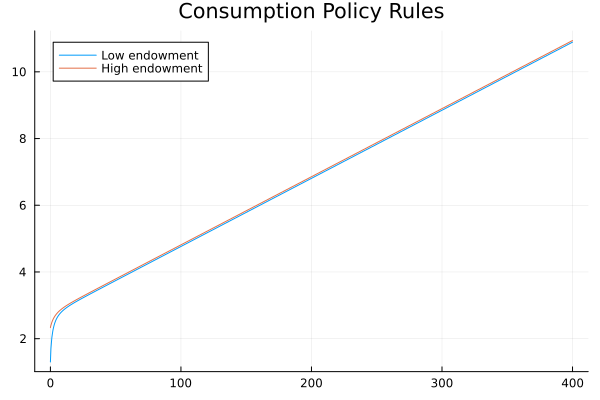

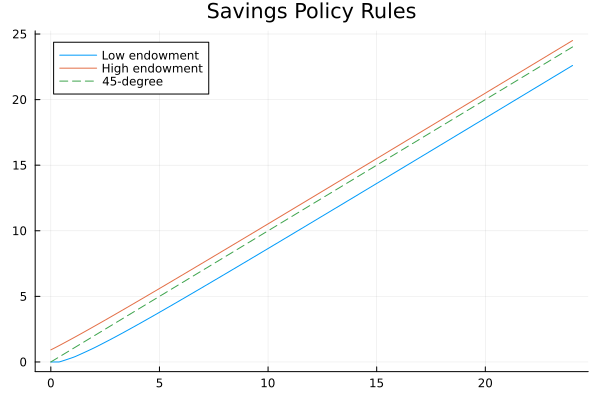

In [27]:
Va, g, c = SolveEGM(ss[:c], [W; R], par, grid)

# Plot consumption policy rules
display(plot(grid.a, c, title="Consumption Policy Rules", label=["Low endowment" "High endowment"]))

# Plot savings policy rules
a_bar = 100
display(plot(grid.a[1:a_bar], [g[1:a_bar, :], grid.a[1:a_bar]], 
             title="Savings Policy Rules", 
             label=["Low endowment" "High endowment" "45-degree"], 
             linestyles=[:solid :solid :dash], 
             colors=[:red :blue :black]))